In [103]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import product
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [104]:
# Read the training data
df_train = pd.read_csv('./Data/BBC News Train.csv')
# Read the test data
df_test = pd.read_csv('./Data/BBC News Test.csv')

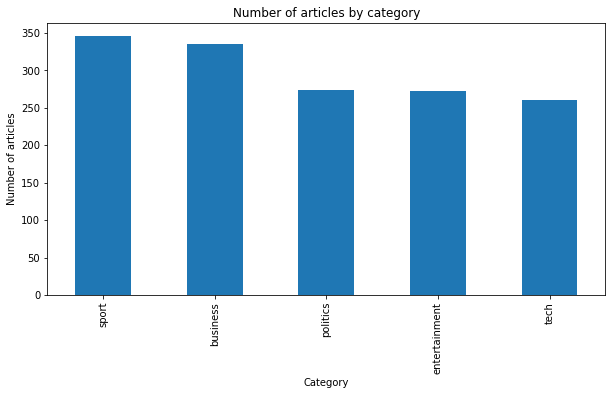

In [105]:
# display by category
df_train['Category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Number of articles by category')
plt.xlabel('Category')
plt.ylabel('Number of articles')
plt.show()

/Users/lntinfotech/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


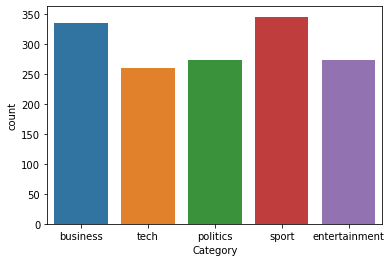

In [106]:
# Plot the distribution of the target variable
sns.countplot(df_train['Category'])
plt.show()


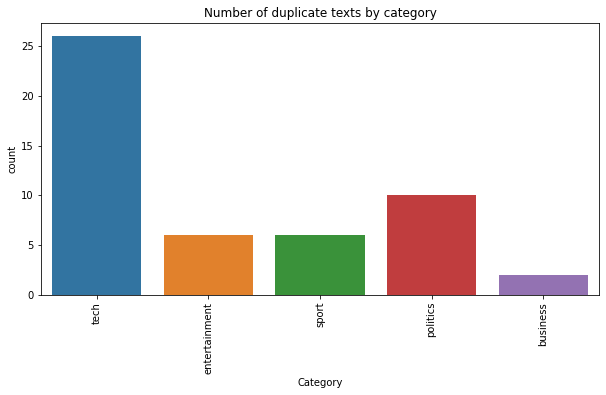

Total number of duplicate texts:  50


In [107]:

# Get the duplicate texts
dup_text = df_train[df_train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text').head(50)
# Plot the number of duplicate text by category
plt.figure(figsize=(10, 5))
# Title of the plot
plt.title('Number of duplicate texts by category')
sns.countplot(x='Category', data=dup_text)
plt.xticks(rotation=90)
plt.show()

# Total number of duplicate texts
print('Total number of duplicate texts: ', len(dup_text))


In [108]:
# Remove the duplicate texts
df_train.drop_duplicates(subset=['Text'], keep='first', inplace=True)
# Reset the index
df_train.reset_index(drop=True, inplace=True)

# Print the shape of the training data
print('Shape of the training data: ', df_train.shape)

Shape of the training data:  (1440, 3)


In [109]:
#Manually encode the target variable
df_train['Category'] = df_train['Category'].map({'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4})
# Print the first 3 rows of the training data
df_train.head(5)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,4
4,917,enron bosses in $168m payout eighteen former e...,0


In [144]:
# Write function to clean the text
import re
import nltk
from nltk.corpus import stopwords

stopwords_en = set(stopwords.words('english'))

def clean_text(text):
    
    # Remove new line and Carriage returns
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\r', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove all numberic and special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stopwords_en])
    return text



   


In [145]:
# Clean the text
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

In [146]:
df_train

,ArticleId,Text,Category
0,1833,worldcom ex boss launch defenc lawyer defend f...,0
1,154,german busi confid slide german busi confid fe...,0
2,1101,bbc poll indic econom gloom citizen major nati...,0
3,1976,lifestyl govern mobil choic faster better funk...,4
4,917,enron boss payout eighteen former enron direct...,0
...,...,...,...
1435,857,doubl evict big brother model capric holbi cit...,1
1436,325,dj doubl act revamp chart show dj duo jk joel ...,1
1437,1590,weak dollar hit reuter revenu media group reut...,0
1438,1587,appl ipod famili expand market appl expand ipo...,4


In [126]:
X_train = df_train['Text']
y_train = df_train['Category']
X_test = df_test['Text']

In [127]:
print('X_train shape ', X_train.shape)
print('y_train shape ', y_train.shape)
print('X_test shape ', X_test.shape)



X_train shape  (1440,)
y_train shape  (1440,)
X_test shape  (735,)


In [128]:
vectorizer = TfidfVectorizer(encoding = 'utf-8', ngram_range = (1,2),stop_words= None,lowercase = False, max_df = 0.95, min_df = 10,norm = 'l2',sublinear_tf = True)

X = vectorizer.fit_transform(X_train).toarray()
tokens = vectorizer.get_feature_names_out()
print('Number of tokens: ', len(tokens))
print('Number of documents: ', len(X_train))
print('Number of features: ', len(X[0]))

Number of tokens:  4026
Number of documents:  1440
Number of features:  4026


In [129]:
X_df = pd.DataFrame(X, columns=tokens)
print(X_df.sum().sort_values().tail(10))


peopl    26.514456
time     26.693898
one      28.329703
new      29.354456
us       29.637318
also     30.319951
would    32.269382
mr       33.650589
year     38.711259
said     52.834603
dtype: float64


In [130]:
print("Weights given to words by idf:")
pd.DataFrame(vectorizer.idf_, vectorizer.get_feature_names_out(), columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
said,1.160765
year,1.413478
also,1.597269
would,1.662397
one,1.724873
...,...
fortnight,5.875197
strain,5.875197
formerli,5.875197
evolv,5.875197


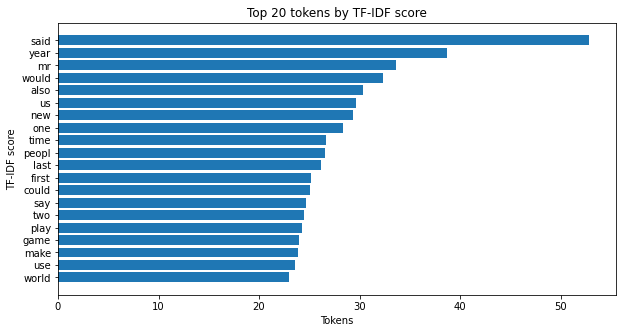

In [131]:
# Plot top 20 tokens by TF-IDF score in descending order with tokens on the x-axis and TF-IDF score on the y-axis
plt.figure(figsize=(10, 5))
plt.title('Top 20 tokens by TF-IDF score')
plt.xlabel('Tokens')
plt.ylabel('TF-IDF score')
plt.barh(range(20), np.sort(X.sum(axis=0))[-20:], align='center')
plt.yticks(range(20), np.array(tokens)[np.argsort(X.sum(axis=0))[-20:]])
plt.show()

In [132]:
# Try with parameter values given in sklean eample
random_state=1
n_components = 5
beta_loss="frobenius"
alpha_W=0.00005
alpha_H=0.00005
l1_ratio=1

nmf = NMF(n_components = 5, random_state = 42, solver = "mu", beta_loss = "kullback-leibler", max_iter= 1000)
model = nmf.fit(X)
W = nmf.fit_transform(X)
H = nmf.components_

/Users/lntinfotech/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/lntinfotech/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [133]:
def display_topics(model, feature_names, num_top_words, topic_names=None):
    '''Print topics and their corresponding words'''
    for ix, topic in enumerate(model.components_):
        print("Topic ", ix)
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [134]:
display_topics(nmf, vectorizer.get_feature_names_out(), 15)

Topic  0
said, year, us, compani, new, bn, also, month, market, would, expect, report, last, uk, sale
Topic  1
play, win, game, player, first, match, champion, final, team, england, time, cup, season, injuri, old
Topic  2
elect, mr, labour, blair, parti, minist, tori, govern, would, say, mr blair, leader, brown, prime minist, prime
Topic  3
film, star, award, music, show, best, includ, actor, movi, nomin, tv, relea, band, oscar, song
Topic  4
use, peopl, technolog, user, comput, phone, mobil, softwar, net, servic, internet, digit, onlin, websit, inform


In [135]:
accuracy_score(y_train , pd.DataFrame(np.argmax(W, axis=1)[:]))

0.5458333333333333

In [136]:
# Find the optimal permutation based on training data
# Get the permutation matrix
perm = np.array([np.argmax(np.bincount(y_train[np.argmax(W, axis=1) == i])) for i in range(n_components)])
# Permute the rows of W
W_perm = W[:, perm]
# Permute the rows of H
H_perm = nmf.components_[perm, :]

# Display accuracy score    
print('Accuracy score: ', accuracy_score(y_train, np.argmax(W_perm, axis=1)))

perm

Accuracy score:  0.9513888888888888


array([0, 3, 2, 1, 4])

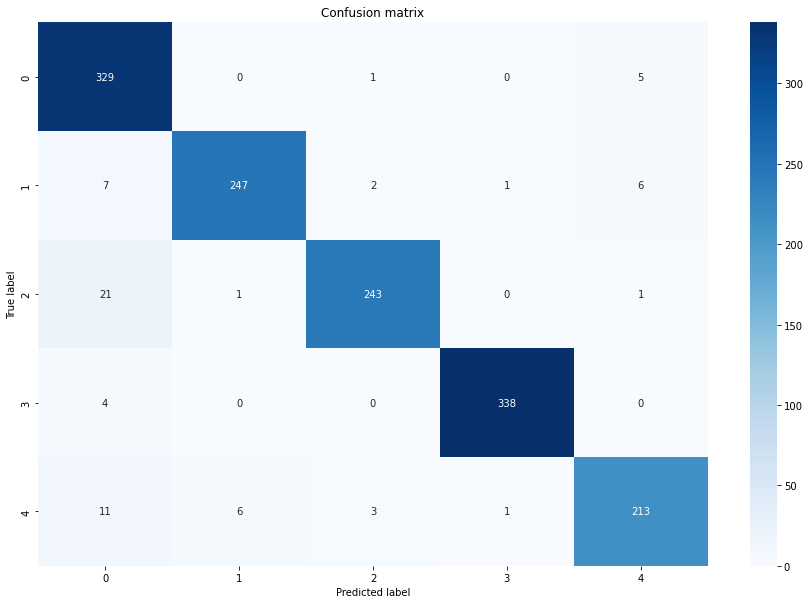

In [137]:
# Permute the rows of the confusion matrix
confusion_matrix_perm = confusion_matrix(y_train, np.argmax(W_perm, axis=1))
# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix_perm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [138]:
# Create a dataframe with articleid, text, category and predicted category
df_pred = pd.DataFrame({'ArticleId': df_train['ArticleId'], 'Text': df_train['Text'], 'Category': df_train['Category'], 'PredictedCategory': np.argmax(W_perm, axis=1)})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['Category'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
df_pred['PredictedCategory'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

,ArticleId,Text,Category,PredictedCategory
0,1833,worldcom ex boss launch defenc lawyer defend f...,business,business
1,154,german busi confid slide german busi confid fe...,business,business
2,1101,bbc poll indic econom gloom citizen major nati...,business,business
3,1976,lifestyl govern mobil choic faster better funk...,tech,tech
4,917,enron boss payout eighteen former enron direct...,business,business
5,1582,howard truant play snooker conserv leader mich...,politics,politics
6,651,wale silent grand slam talk rhi william say wa...,sport,sport
7,1797,french honour director parker british film dir...,entertainment,entertainment
8,2034,car giant hit merc slump slump profit luxuri c...,business,business
9,1866,focker fuel festiv film chart comedi meet fock...,entertainment,entertainment


In [139]:

X_ = vectorizer.fit_transform(df_test['Text']).toarray()
y_hat = nmf.fit_transform(X_)
#index with highest probability is our predicted class
y_hat = np.argmax(y_hat, axis=1)

# create dataframe
y_hat = pd.DataFrame(y_hat)

# assign best labelorder to prediction
y_hat = y_hat.replace(np.unique(y_hat), [0, 3, 2, 1, 4])
y_hat.head()

/Users/lntinfotech/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


,0
0,3
1,1
2,3
3,0
4,3


In [140]:
# Create a dataframe with articleid, text and predicted category
df_pred = pd.DataFrame({'ArticleId': df_test['ArticleId'],  'PredictedCategory': y_hat[0]})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

# Remove predicted category column
df_pred.drop('PredictedCategory', axis=1, inplace=True)


In [141]:
df_pred.shape
df_pred.to_csv('submission.csv', index=False)